## Imports

In [ ]:
# your imports and initial checks here
!pip install -q pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from os import listdir
from PIL import Image

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

# mount drive
from google.colab import drive
drive.mount('/content/gdrive/')

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

     |████████████████████████████████| 66 kB 2.2 MB/s 
     |████████████████████████████████| 590 kB 10.7 MB/s 
     |████████████████████████████████| 793 kB 53.5 MB/s 
     |████████████████████████████████| 381 kB 62.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.
Populating the interactive namespace from numpy and matplotlib
Mounted at /content/gdrive/
No GPU available!


## 1-Load the medical MNIST dataset
[kaggle dataset](https://www.kaggle.com/datasets/andrewmvd/medical-mnist/code)

In [ ]:
# Get kaggle authentication json
! pip install -q kaggle
from google.colab import files
# https://www.kaggle.com/general/74235
# create API token, download kaggle.json locallly, then upload to Google Drive
files.upload() 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! ls ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
# Download and unzip dataset
! kaggle datasets download -d andrewmvd/medical-mnist
! mkdir ./medical-mnist
! unzip -q ./medical-mnist.zip -d medical-mnist

 77% 65.0M/84.8M [00:00<00:00, 187MB/s]
100% 84.8M/84.8M [00:00<00:00, 179MB/s]


Length of dataset:  58954
Shape of image:  (64, 64, 3)



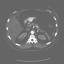

In [ ]:
# load images without grayscale transformation as Image object
no_grayscale = datasets.ImageFolder('./medical-mnist/')

print('Length of dataset: ', len(no_grayscale))

# check shape of an Image object
img, label = no_grayscale[0]
print('Shape of image: ', np.shape(np.asarray(img)))

# plot an example
# https://plotly.com/python/imshow/
# https://plotly.com/python/setting-graph-size/
import plotly.express as px
fig = px.imshow(img)
fig.update_layout(autosize=False, width=300, height=300)
fig.show()

In [ ]:
# load images from directory as Image object and transform them to grayscale
dataset = datasets.ImageFolder('./medical-mnist/', transform=transforms.Grayscale())

print('Length of dataset: ', len(dataset))

# check shape of an Image
img, label = dataset[0]
print('Shape of image: ', np.shape(np.asarray(img)))

Length of dataset:  58954
Shape of image:  (64, 64)


By converting the images to grayscale, the number of input channels is reduced from $3$ to $1$, so the number of parameters that needs to be trained in the input layer is reduced by one third. Moreover, the original image is already in black and white, so information would not be lost when converted to grayscale. Also, the features that are key to classifying these medical images are not dependent on colour.

## 2-Plot data
Plot 25 images of the training set together with their corresponding label names.






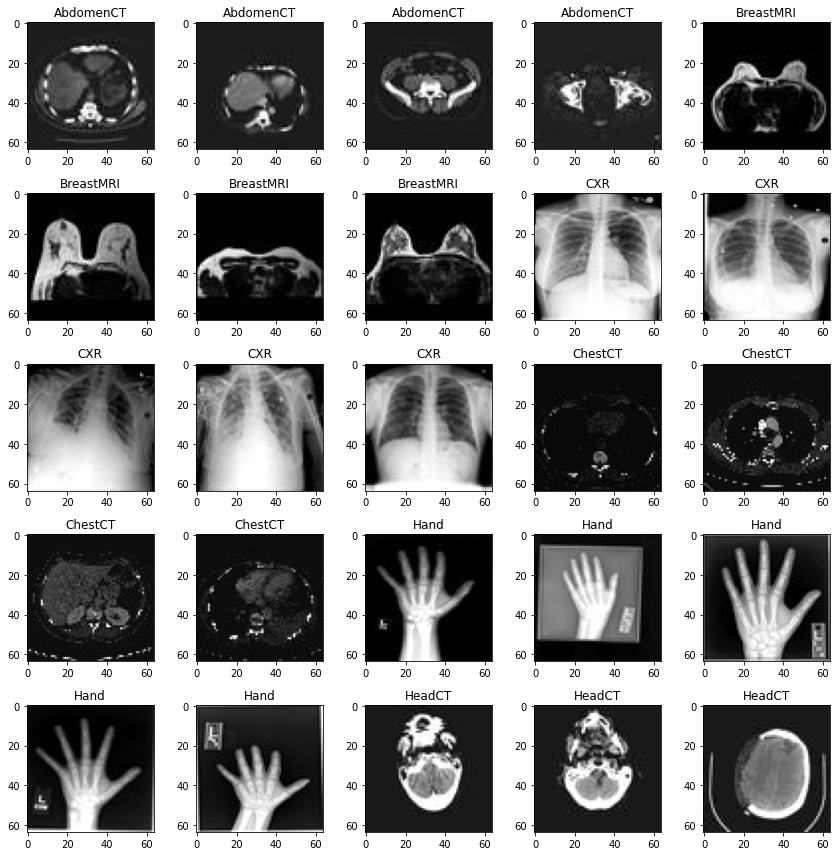

In [ ]:
# your code goes here
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    # multiply i by 2200 to plot across all labels
    img, label = dataset[2200*i]
    plt.imshow(np.asarray(img), cmap='gray')
    # set corresponding label name as title
    plt.title(dataset.classes[label])
plt.show()

### 25 images of training set with label names

<img src='https://drive.google.com/uc?id=1Hd3I0i6ZO5xOw7b8_dRKPpfcgvoc0S31'>

## 3-Prepare LeNet-5 network

$1$ input channel in C1.

Input image size is $64×64$. The output image size across convolutional and pooling layers is calculated from input image size $n×n$, kernel size $f×f$, padding $p$ and stride $s$:

$$\frac{n+2p-f}{s}+1×\frac{n+2p-f}{s}+1$$

In [ ]:
#     make modifications in the code below

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # one input channel
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1) # 60x60
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)   # 30x30
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)   # 26x26
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2) # 13x13
    self.c5 = nn.Linear(16*13*13, 120)    
    self.f6 = nn.Linear(120, 84)   
    self.output = nn.Linear(84, 6)  # 6 labels instead of 10
    self.act = nn.ReLU()           
    
  def forward(self, x):
    x = self.act(self.c1(x))    
    x = self.act(self.s2(x))   
    x = self.act(self.c3(x))   
    x = self.act(self.s4(x))    
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))     
    x = self.act(self.c5(x))       
    x = self.act(self.f6(x))    
    return self.output(x)          
  
# Dummy input of the same size as the Medical-MNIST images
## generate a dummy tensor x
x = torch.randn((1, 1, 64, 64))
## get an instance of your model and call it model
model = LeNet5() # if you have called your instance something different than model, modify this line of code
y = model(x)
print(model)
print(x.shape, y.shape)

LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)
torch.Size([1, 1, 64, 64]) torch.Size([1, 6])


## 4-Create a training, validation split
Split the data using `sklearn.model_selection.StratifiedShuffleSplit`:

- 90\% of the data in the training set
- 10\% of the data in the validation set

Verify the stratified shuffle split by plotting a histogram of the classes in the training and validation set.

Prepare the downloaded datasets to be used.

In [ ]:
X_list = []

# go over Image objects in data set and add them into X_list as numpy array
for i in range(len(dataset)):
  img, label = dataset[i]
  X_list.append(np.asarray(img))

# convert X_list to numpy array
X_list = np.array(X_list)
# create tensor from X_list
X = torch.Tensor(X_list)
# convert list of labels to torch tensor
y = torch.Tensor(np.array(dataset.targets))

# check shapes of X and y
print(X.shape)
print(y.shape)

torch.Size([58954, 64, 64])
torch.Size([58954])


Overall, I split the dataset into $3$ sets: training set, validation set and testing set. 

I split 10% of the dataset to test set. Within the remaining 90%, I split 90% for training set and 10% for validation set. This is done so that the test data is not used in the whole training process, including optimising for hyperparameters, and is only used for final evaluation.

In [ ]:
# split dataset into training, validation and testing

# split 10% dataset as test, used to test model after selecting optimal hyperparameters
# set random_state=0 for reproducible output
indices = StratifiedShuffleSplit(test_size=0.1, random_state=0).split(X, y)
train_valid_index, test_index = list(indices)[0]
X_train_valid, X_test = X[train_valid_index], X[test_index]
y_train_valid, y_test = y[train_valid_index], y[test_index]

# split the remaining 90% of the dataset i.e. X_train_valid into 90% training, 10% validation
# set random_state=0 for reproducible output
train_valid_indices = StratifiedShuffleSplit(test_size=0.1, random_state=0).split(X_train_valid, y_train_valid)
train_index, valid_index = list(train_valid_indices)[0]
X_train, X_valid = X_train_valid[train_index], X_train_valid[valid_index]
y_train, y_valid = y_train_valid[train_index], y_train_valid[valid_index]

# create the TensorDatasets for training, validation and testing
# set y to long data type so that it works with Pytorch
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_valid, y_valid.long())
mnist_test = TensorDataset(X_test, y_test.long())

# create TensorDataset for the whole dataset
mnist_all = TensorDataset(X, y.long())

{'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


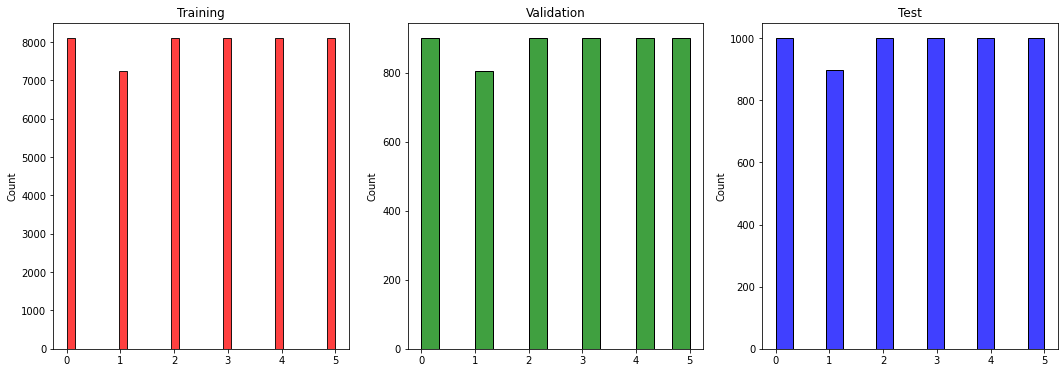

In [ ]:
# print out the dictionary that maps between label name and index
print(dataset.class_to_idx)


fig, ax =plt.subplots(1,3, figsize=(18, 6))
sns.histplot(y_train, ax=ax[0], color='r')
sns.histplot(y_valid, ax=ax[1], color='g')
sns.histplot(y_test, ax=ax[2], color='b')
ax[0].set_title('Training')
ax[1].set_title('Validation')
ax[2].set_title('Test')
fig.show()

#### Histogram of training, validation, and testing sets

<img src='https://drive.google.com/uc?id=1MDXgSaJ9z-8x0Pdq4sxTcBc0DOfJtt9w'>

## 5-Grid search
Select  two  hyperparameters  and  perform  a  2D  grid-search  to  find  the  optimal values for these two hyperparameters.  

In [ ]:
# your code goes here
seed = 42
# grid search for learning rate
lrs = [1e-1, 1e-2, 1e-3]
# grid search for momentum
momentums = [0.2, 0.5, 0.8]
batch_size = 64
test_batch_size = 1000
epochs = 30

### Why I chose to optimise learning rate and momentum

Learning rate $\alpha$ is the first model parameter I chose to optimise. Given loss function $J$ and model parameters $θ$, the model parameters are updated by:

$$\theta_b=\theta_a-α\frac{δ J(\theta_a)}{δ θ}.$$

From this, the learning rate directly determines how large the gradient descent step should be, how much the model parameters should be updated, and in which direction they should be updated, thus learning rate affects if the global minimum of the loss function can be reached and how quickly it can be reached. By optimising learning rate, the model with the least loss can be found reliably and quickly.

The second hyperparameter I chose to optimise is momentum, which increases when the gradients point in the same direction and decreases when the gradients change direction. As a result, convergence is faster and more stable, since the model update continues along the same direction even if the gradients change direction temporarily, such as when it encounters a local minimum. With the right momentum, an accurate model can be found more reliably and quickly.

In [ ]:
# training, validation and evaluation functions modified from practical 4

def train(model, optimizer, criterion, data_loader):
    model.train() # set model to training mode to optimise model parameters
    train_loss, train_accuracy = 0, 0 # initialise training loss and training accuracy to 0
    for X, y in data_loader: # iterate over mini-batch with batch size defined in data loader (batch_size)
        X, y = X.to(device), y.to(device) # send data to device (GPU)
        optimizer.zero_grad() # reset all gradients to 0
        a2 = model(X.view(-1, 1, 64, 64)) # forward pass, image size is 64x64
        loss = criterion(a2, y) # compute loss (cross entropy loss)
        loss.backward() # backward propagation to compute gradients
        train_loss += loss*X.size(0) # compute training losses, add up over mini-batch to undo normalization
        y_pred = F.log_softmax(a2, dim=1).max(1)[1] # compute prediction using model
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy from prediction
        optimizer.step() # update model parameters by gradient descent step
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset) # average loss and accuracy over whole dataset
  
def validate(model, criterion, data_loader):
    model.eval() # set model to evaluation model so that model parameters remain unchanged
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0
    for X, y in data_loader: # iterate over mini-batch with batch size defined in data loader (test_batch_size)
        with torch.no_grad(): # disable gradient computation, ensure backward() cannot be called and no gradient descent step is taken
            X, y = X.to(device), y.to(device) # send data to device (GPU)
            a2 = model(X.view(-1, 1, 64, 64)) # forward pass, image size is 64x64
            loss = criterion(a2, y) # compute loss (cross entropy loss)
            validation_loss += loss*X.size(0) # compute validation losses, add up over mini-batch to undo normalization
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # compute prediction using model
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy from prediction
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset) # average loss and accuracy over whole dataset
  
def evaluate(model, data_loader):
    model.eval() # set model to evaluation model so that model parameters remain unchanged
    ys, y_preds = [], [] # initialise lists to store labels (ys) and predictions (y_preds)
    for X, y in data_loader: # iterate over mini-batch with batch size defined in data loader (test_batch_size)
        with torch.no_grad(): # disable gradient computation, ensure backward() cannot be called and no gradient descent step is taken
            X, y = X.to(device), y.to(device) # send data to device (GPU)
            a2 = model(X.view(-1, 1, 64, 64)) # forward pass, image size is 64x64
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # compute prediction using model
            ys.append(y.cpu().numpy()) # save label
            y_preds.append(y_pred.cpu().numpy()) # save prediction
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0) # concatenate the labels and predictions of each batch into a single list

In [ ]:
# train_model function modified from lecture 4 that accepts momentum and learning rate as argument

def train_model(momentum, lr):
    set_seed(seed) # ensure reproducible output
    model = LeNet5().to(device) # send model to device (GPU)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) # define optimizer as SGD with momentum
    criterion = nn.CrossEntropyLoss() # define criterion to compute loss as cross entropy

    # create a train_loader for loading training data
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
    # create a validation_loader for loading validation data
    validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)

    # plot accuracy and loss over epoch for training and validation
    liveloss = PlotLosses()
    for epoch in range(30):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

    return model

## Summary tables

### Accuracy

| Learning rate | Momentum | Training accuracy | Validation accuracy |
| --- | --- | --- | --- |
| 0.1 | 0.8 | 0.169 | 0.170 |
| 0.01 | 0.8 | 0.818| 0.822 |
| 0.01 | 0.5 | 1.000 | 0.998 |
| 0.01 | 0.2 | 1.000 | 0.997 |
| 0.001 | 0.8 | 1.000 | 0.999 |
| 0.001 | 0.5 | 1.000 | 0.998 |
| 0.001 | 0.2 | 1.000 | 0.995 |

### Log Loss

| Learning rate | Momentum | Training loss | Validation loss |
| --- | --- | --- | --- |
| 0.1 | 0.8 | 1.793 | 1.793 |
| 0.01 | 0.8 | 0.290| 0.271 |
| 0.01 | 0.5 | 0.000 | 0.013 |
| 0.01 | 0.2 | 0.000 | 0.016 |
| 0.001 | 0.8 | 0.000 | 0.011 |
| 0.001 | 0.5 | 0.001 | 0.010 |
| 0.001 | 0.2 | 0.001 | 0.011 |

## Grid search run plots

### Learning rate = 0.1, momentum = 0.8



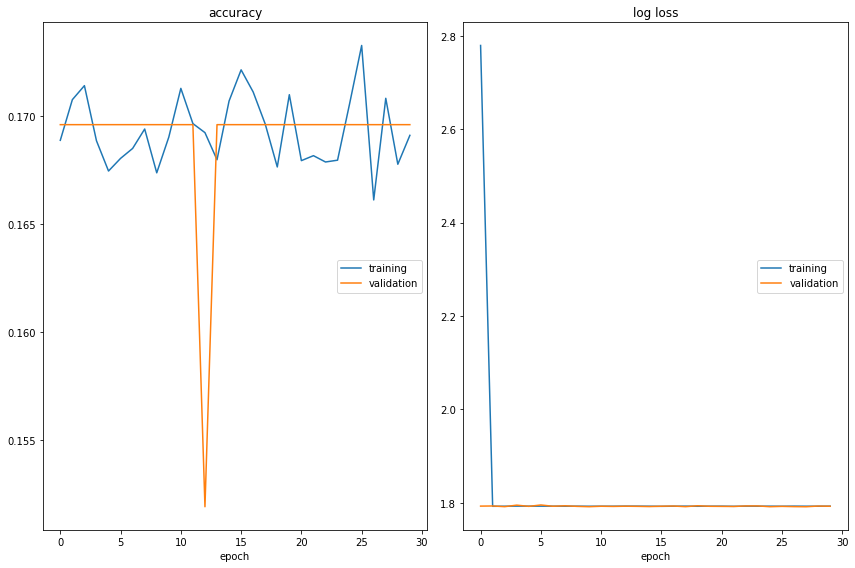

accuracy
	training         	 (min:    0.166, max:    0.173, cur:    0.169)
	validation       	 (min:    0.152, max:    0.170, cur:    0.170)
log loss
	training         	 (min:    1.792, max:    2.780, cur:    1.793)
	validation       	 (min:    1.792, max:    1.795, cur:    1.793)


LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)

In [ ]:
# momentum = 0.8, learning rate = 1e-1
train_model(momentums[2], lrs[0])

#### Liveloss plot

<img src='https://drive.google.com/uc?id=1E-iDRN-a01bWXqz_6BwqZVa8m59w-mcZ'>

The model does not improve and has very poor performance -- it is essentially guessing randomly, as shown by its accuracy of $17\%$ i.e. $\frac{1}{6}$.

From this, setting learning rate to $0.1$ can be excluded.

### Learning rate = 0.01, momentum = 0.8

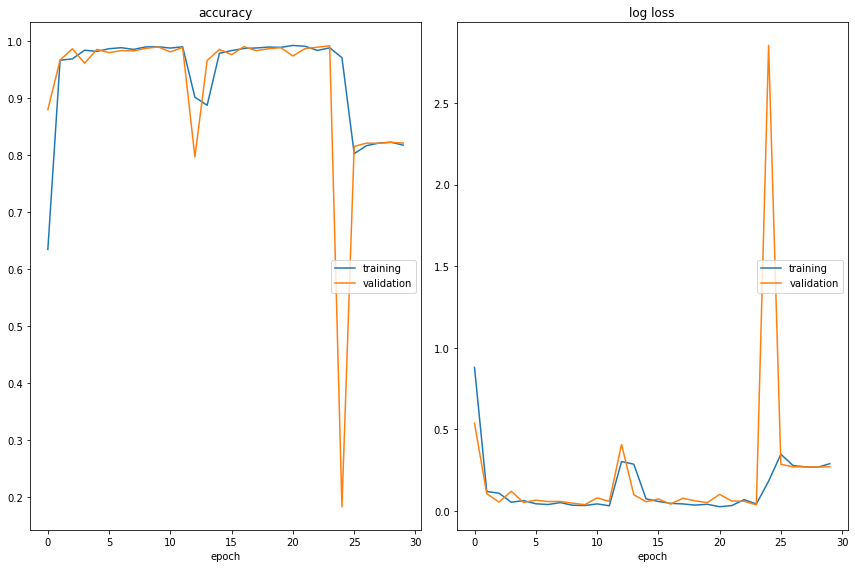

accuracy
	training         	 (min:    0.635, max:    0.993, cur:    0.818)
	validation       	 (min:    0.183, max:    0.992, cur:    0.822)
log loss
	training         	 (min:    0.025, max:    0.880, cur:    0.290)
	validation       	 (min:    0.037, max:    2.854, cur:    0.271)


LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)

In [ ]:
# momentum = 0.8, learning rate = 1e-2
train_model(momentums[2], lrs[1])

#### Liveloss plot

<img src='https://drive.google.com/uc?id=1r_3EBywhdyaVQB6D8vWoxy2RP8XoWvwI'>

Both training and validation sets are unstable during the training process, and the final trained model has relatively low accuracy of 82% for both training and validation sets.

### Learning rate = 0.01, momentum = 0.5

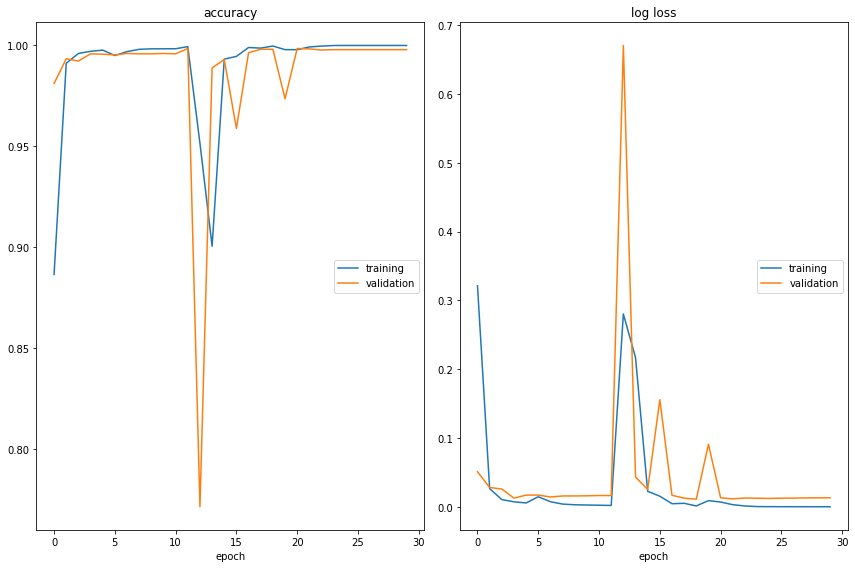

accuracy
	training         	 (min:    0.887, max:    1.000, cur:    1.000)
	validation       	 (min:    0.771, max:    0.998, cur:    0.998)
log loss
	training         	 (min:    0.000, max:    0.321, cur:    0.000)
	validation       	 (min:    0.011, max:    0.670, cur:    0.013)


LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)

In [ ]:
# momentum = 0.5, learning rate = 1e-2
train_model(momentums[1], lrs[1])

#### Liveloss plot

<img src='https://drive.google.com/uc?id=10R1BWeZjoo6e2_8YMWFvfKLOEcB1DVUC'>

The final trained model has very high accuracy in training (1.000) and validation (0.998) sets, but the training process is still unstable, most noticeably in the 12th epoch.

### Learning rate = 0.01, momentum = 0.2

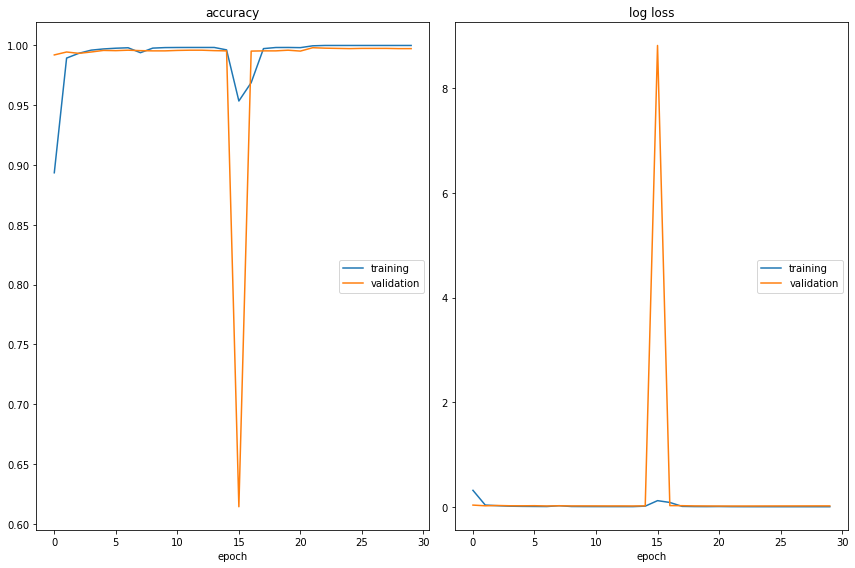

accuracy
	training         	 (min:    0.894, max:    1.000, cur:    1.000)
	validation       	 (min:    0.614, max:    0.998, cur:    0.997)
log loss
	training         	 (min:    0.000, max:    0.314, cur:    0.000)
	validation       	 (min:    0.013, max:    8.823, cur:    0.016)


LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)

In [ ]:
# momentum = 0.2, learning rate = 1e-2
train_model(momentums[0], lrs[1])

#### Liveloss plot

<img src='https://drive.google.com/uc?id=1uYbXdSn_cp_Rj68qjinsPN-weoC_f3-Y'>

Training process is mostly stable except at the 15th epoch, where a large dip in validation accuracy and a large rise in validation loss can be seen. Final model has very high accuracy and very low loss in both training and validation sets.

### Learning rate = 0.001, momentum = 0.8


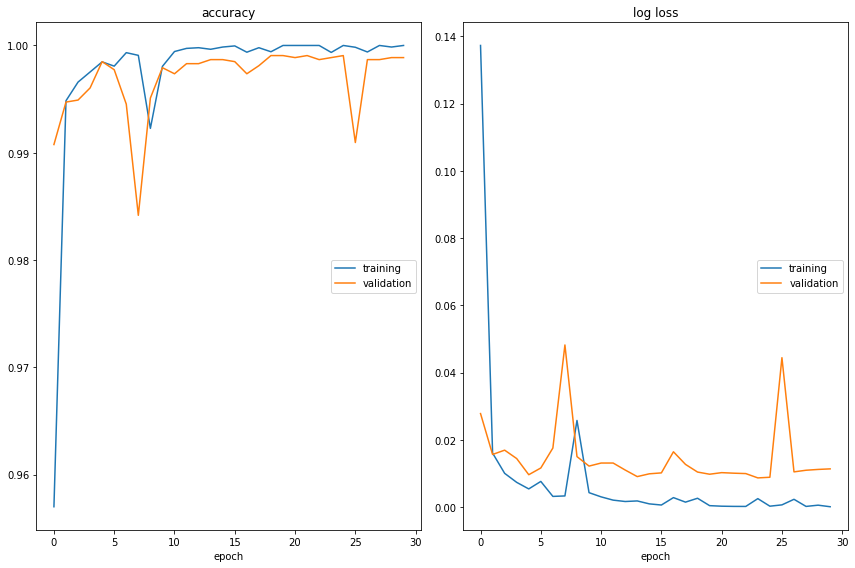

accuracy
	training         	 (min:    0.957, max:    1.000, cur:    1.000)
	validation       	 (min:    0.984, max:    0.999, cur:    0.999)
log loss
	training         	 (min:    0.000, max:    0.137, cur:    0.000)
	validation       	 (min:    0.009, max:    0.048, cur:    0.011)


LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)

In [ ]:
# momentum = 0.8, learning rate = 1e-3
train_model(momentums[2], lrs[2])

#### Liveloss plot

<img src='https://drive.google.com/uc?id=11X9goJFda52HLHWvWAF-mcJxOhuQ0dW9'>

Training process with these hyperparameters is relatively unstable, but it has very high training accuracy (1.000), validation accuracy (0.999), zero training loss, and low validation loss (0.011).

### Learning rate = 0.001, momentum = 0.5



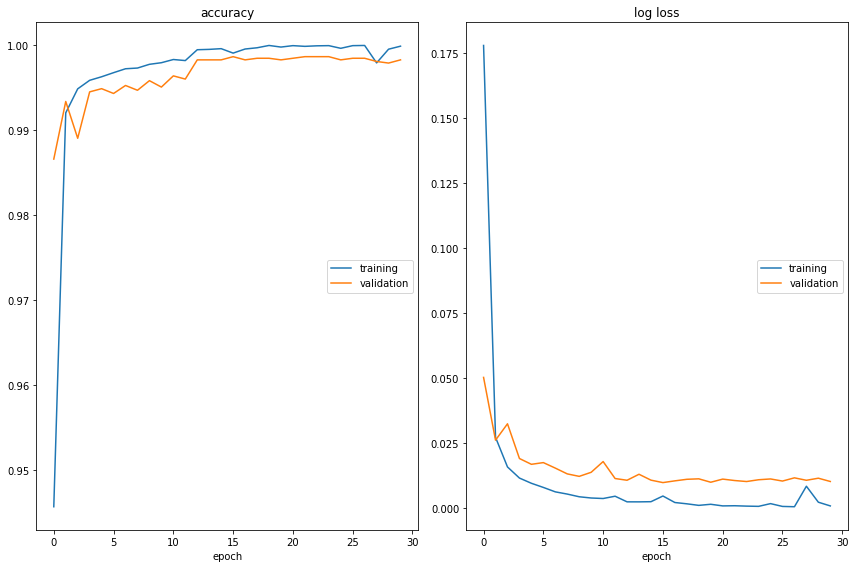

accuracy
	training         	 (min:    0.946, max:    1.000, cur:    1.000)
	validation       	 (min:    0.987, max:    0.999, cur:    0.998)
log loss
	training         	 (min:    0.001, max:    0.178, cur:    0.001)
	validation       	 (min:    0.010, max:    0.050, cur:    0.010)


LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)

In [ ]:
# momentum = 0.5, learning rate = 1e-3
train_model(momentums[1], lrs[2])

#### Liveloss plot

<img src='https://drive.google.com/uc?id=1ELQltKpIzlWVXWhI12SxsM6rgeC4362Y'>

Training process is very stable, final model has very high accuracy and very low loss in both training and validation sets.

### Learning rate = 0.001, momentum = 0.2

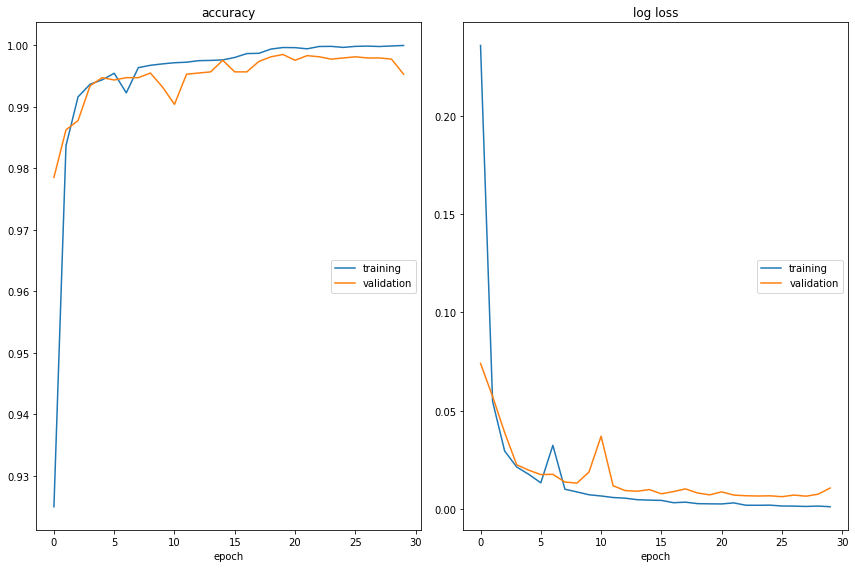

accuracy
	training         	 (min:    0.925, max:    1.000, cur:    1.000)
	validation       	 (min:    0.979, max:    0.998, cur:    0.995)
log loss
	training         	 (min:    0.001, max:    0.236, cur:    0.001)
	validation       	 (min:    0.006, max:    0.074, cur:    0.011)


LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)

In [ ]:
# momentum = 0.2, learning rate = 1e-3
train_model(momentums[0], lrs[2])

#### Liveloss plot

<img src='https://drive.google.com/uc?id=1vArOVHt78X_67ygiwHB-vDKFoGJm5hH_'>

Training process is fairly stable. The difference in accuracy of the final model between training set and validation set is the largest out of the tested models, hence it shows signs of overfitting.

### Hyperparameter selection

Considering stability during training and performance of the final model, the only two sets of hyperparameters worth considering are (learning rate = 0.001, momentum = 0.5) and (learning rate = 0.001, momentum = 0.2). 

I have chosen the former set of hyperparameters i.e. learning rate = 0.001 and momentum = 0.5, due to higher validation accuracy, as well as slightly more stable training process.

## 6-Train with best hyperparameters

In [ ]:
# set hyperparameters

seed = 42
lr = 1e-3 # best learning rate
momentum = 0.5 # best momentum
batch_size = 64
test_batch_size = 1000
epochs = 30

I used `X_train_valid` to retrain the model, which is the dataset before it is split to `X_train` and `X_valid` using `StratifiedShuffleSplit`, so it is the combination of training set and validation set. Since the hyperparameters are already chosen, the validation set is no longer needed. Also, as the training set becomes larger, the model could be trained to be more accurate. More importantly, the training set is not compromised.

In [ ]:
# X_train_valid combines X_train and X_valid
my_model_train = TensorDataset(X_train_valid, y_train_valid.long())

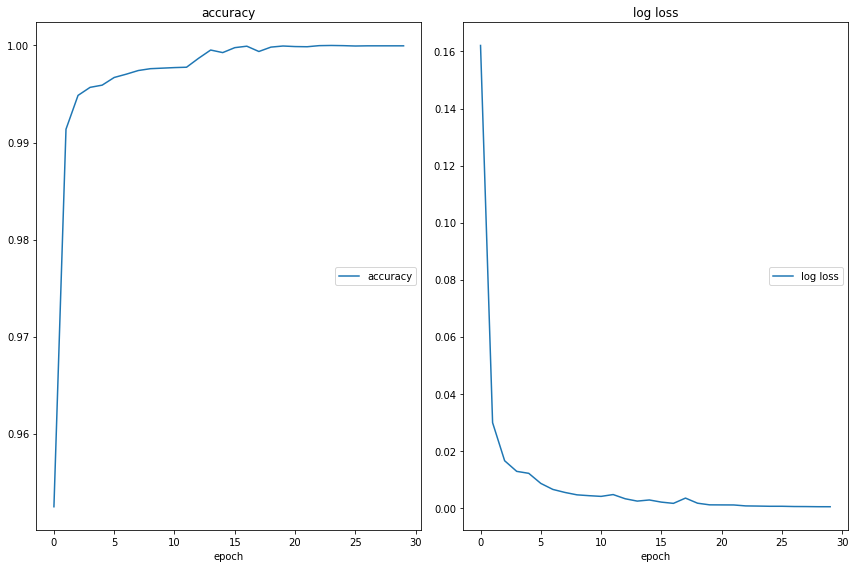

accuracy
	accuracy         	 (min:    0.952, max:    1.000, cur:    1.000)
log loss
	log loss         	 (min:    0.000, max:    0.162, cur:    0.000)


In [ ]:
set_seed(seed) # ensure reproducible output
my_model = LeNet5().to(device) # define model and send model to device
optimizer = torch.optim.SGD(my_model.parameters(), lr=lr, momentum=momentum) # define optimizer as SGD with momentum
criterion = nn.CrossEntropyLoss() # define criterion to compute loss as cross entropy

# create a train_loader for loading training data
my_model_train_loader = DataLoader(my_model_train, batch_size=batch_size, shuffle=True, num_workers=0)

# plot accuracy and loss over epoch during training
liveloss = PlotLosses()
for epoch in range(30):
    logs = {}
    train_loss, train_accuracy = train(my_model, optimizer, criterion, my_model_train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

#### Liveloss plot

<img src='https://drive.google.com/uc?id=1-534OPT5X1ahBmtfy9s8HID5b2FciHXy'>

In [ ]:
# create test_loader for loading test set
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

# compute test loss and test accuracy
test_loss, test_accuracy = validate(my_model, criterion, test_loader)
print("Test Loss: %1.3f" % test_loss.item(), "Test Accuracy: %1.3f" % test_accuracy.item())

Test Loss: 0.003 Test Accuracy: 0.999


In [ ]:
# save model to drive
model_save_name = 'LeNet5_medical_mnist.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(my_model.state_dict(), path)

Mounted at /content/gdrive/


In [ ]:
criterion = nn.CrossEntropyLoss() # define criterion to compute loss as cross entropy
# test that the same model can be loaded from drive
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

model_save_name = 'LeNet5_medical_mnist.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
# creates an instance of the model
load_model = LeNet5().to(device) 
# loads the parameters of the model in path
load_model.load_state_dict(torch.load(path))

# check test loss and test accuracy of loaded_model are the same as above
load_test_loss, load_test_accuracy = validate(load_model, criterion, test_loader)
print("Test Loss: %1.3f" % load_test_loss.item(), "Test Accuracy: %1.3f" % load_test_accuracy.item())

Test Loss: 0.003 Test Accuracy: 0.999


## Visualise loss landscapes

In [ ]:
# The following snippets of code are only to assist you. You can decide to use 
# them or not. They are only intended to provide you with some functionality
#  you may find useful when trying to generate the loss landscape plots.


# function to create random directions:
def create_random_directions(weights, ignore1D=False, seed=42):
    torch.manual_seed(seed)
    direction = [torch.randn(w.size()).to(device) for w in weights]
    
    # apply filter normalisation, where every perturbation d in direction has the same norm as its corresponding w in weights
    for d, w in zip(direction, weights):
        if ignore1D and d.dim() <= 1:
            d.fill_(0)
        d.mul_(w.norm()/(d.norm() + 1e-10)) # add small perturbation to avoid division by zero

    return direction


# function to update weigths
def update_weights(model, origin_weights, x_dir, y_dir, dx=0.1, dy=0.1):
    updates = [x.to(device)*dx + y.to(device)*dy for (x, y) in zip(x_dir, y_dir)]
    for (p, w, u) in zip(model.parameters(), origin_weights, updates):
        p.data = w.to(device) + u.to(device)
    return None


# function to plot loss landscape as a surface
def plot_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(8, 8),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, loss_landscape, cmap='viridis', edgecolor='none',
                       linewidth=0, antialiased=True,  rstride=1, cstride=1,)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    ax.set_zlabel(r'Loss')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# function to plot loss landscape as a contour
def contour_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(7, 7))
    surf = ax.contourf(xx, yy, loss_landscape, cmap='viridis', levels=100)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# BONUS: functions to compute the angle between 2 random vectors
# in high-dimensional spaces two random vectors are quite likely to be
# orthogonal (or almost). No points involved here, this is just for fun!
#
def angle(vec1, vec2):
    return torch.acos(torch.dot(vec1, vec2)/(vec1.norm()*vec2.norm())).item()

def rad2deg(angle):
    return angle*180/np.pi

def concat_torch_list(torch_list):
    for i, t in enumerate(torch_list):
        torch_list[i] = t.flatten()
    return torch.cat(torch_list)

In [ ]:
### takes 23 minutes to run with GPU

# creates an instance of the model
final_trained_model = LeNet5().to(device) 

# load the parameters of my final trained model from path
model_save_name = 'LeNet5_medical_mnist.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
final_trained_model.load_state_dict(torch.load(path))

# store weights from my final trained model in list
weights = []
for param in final_trained_model.parameters():
  weights.append(param)

# store weights from randomly initialised model in list
random_model = LeNet5().to(device)
weights_random = []
for param in random_model.parameters():
  weights_random.append(param)

# generate two lists of filter vectors delta and eta
# set seed with different value so that the list is different
delta = create_random_directions(weights)
eta = create_random_directions(weights, seed=0)
delta_random = create_random_directions(weights_random)
eta_random = create_random_directions(weights_random, seed=0)

# generate alpha and beta values
alphas = np.linspace(-10., 10., 25)
betas = np.linspace(-10., 10., 25)

# create grid for surface and contour plot
Alphas, Betas = np.meshgrid(alphas, betas)

# create grid to store loss
losses = np.zeros_like(Alphas)
losses_random = np.zeros_like(Alphas)

# data loader to load test data set
data_loader = DataLoader(mnist_all, batch_size=test_batch_size, shuffle=False, num_workers=0)
# loss computed from cross entropy
criterion = nn.CrossEntropyLoss()

# go over grid
for i in range(25):
  # scale filters in delta by alpha
  dir1 = [alphas[i]*tensor for tensor in delta]
  dir1_random = [alphas[i]*tensor for tensor in delta_random]
  for j in range(25):
    # scale filters in eta by beta
    dir2 = [betas[j]*tensor for tensor in eta]
    dir2_random = [betas[j]*tensor for tensor in eta_random]
    # restore original weights in final trained model
    final_trained_model.load_state_dict(torch.load(path))
    # update weights in filters in final trained model and compute loss
    update_weights(final_trained_model, weights, dir1, dir2)
    test_loss, test_accuracy = validate(final_trained_model, criterion, data_loader)
    losses[i][j] = test_loss.item()
    # restore original weights in randomly initialised model
    random_model = LeNet5().to(device)
    # update weights in filters in random model and compute loss
    update_weights(random_model, weights_random, dir1_random, dir2_random)
    # compute loss using validate function
    loss, accuracy = validate(random_model, criterion, data_loader)
    # add loss to grid
    losses_random[i][j] = loss.item()


Min loss: 0.0005261186743155122
Index of min loss: [12, 12]


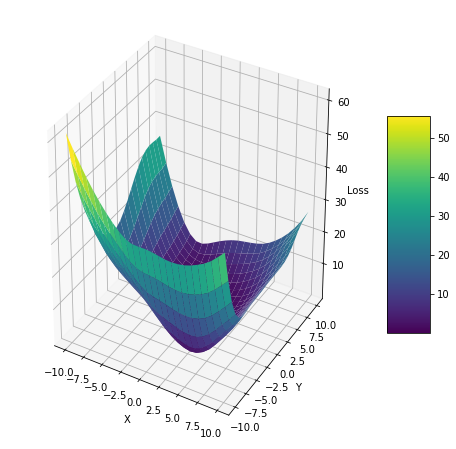

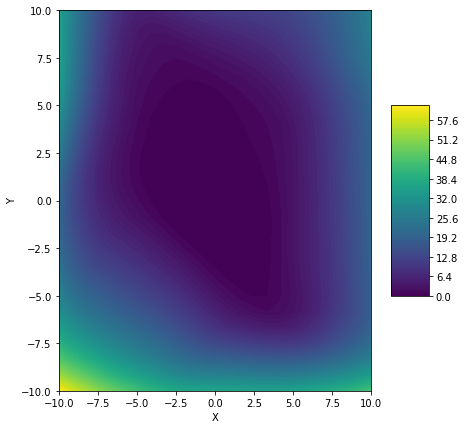

In [ ]:
print('Min loss:', np.min(losses))
idx0, idx1 = np.where(losses == np.min(losses))
print('Index of min loss: [%.d, %.d]' % (idx0[0], idx1[0]))

# surface and contour plot for final trained model
plot_loss_landscape(Alphas, Betas, losses)
contour_loss_landscape(Alphas, Betas, losses)

#### Final trained model loss landscape

<img src='https://drive.google.com/uc?id=1_LjV0FkQyA8emPlP76Y9MnygpYq5oQPO'>

<img src='https://drive.google.com/uc?id=1jx0Z0DkcXa4Yvnq51r9i5kKBMmBhrggT'>

Min loss: 2.9996626377105713
Index of min loss: [10, 10]


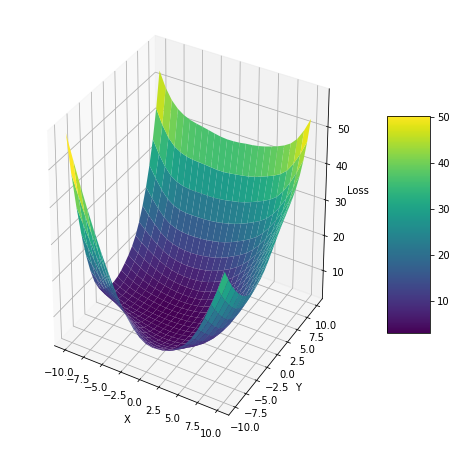

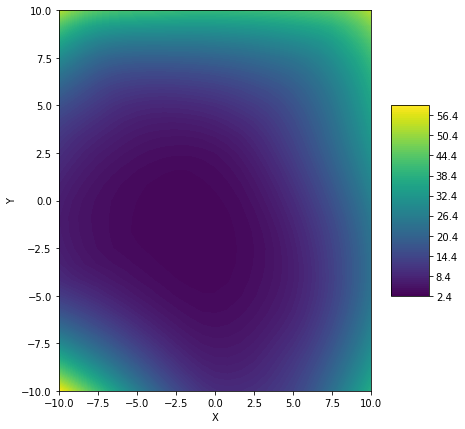

In [ ]:
print('Min loss:', np.min(losses_random))
idx0, idx1 = np.where(losses_random == np.min(losses_random))
print('Index of min loss: [%.d, %.d]' % (idx0[0], idx1[0]))

# surface and contour plot for random model
plot_loss_landscape(Alphas, Betas, losses_random)
contour_loss_landscape(Alphas, Betas, losses_random)

#### Random model loss landscape

<img src='https://drive.google.com/uc?id=1kPrBxKzQIwtrVTXSOMsWCCVybVT9WmlP'>

<img src='https://drive.google.com/uc?id=1yN_bc1GuB7zdX7xuK4MmFWpauMqeeOmk'>

I used the whole dataset `mnist_all` to generate these loss landscape plots, because I am no longer training the model and tuning its hyperparameters, so I need not be concerned about generalization error; the focus here is to examine the effect of perturbing parameters on the loss, not the accuracy or loss when applied generally to data outside of this dataset. The effect of using the whole dataset is that the loss computed will be lower than if only the test set is used, because the number of trainable parameters (337,846) is much larger than the number of images (58955), so overfitting is inevitable and the train loss will be lower than test loss in the trained model. This is shown by the fact that the minimum loss from the trained model landscape plot (0.0005) is lower than the model loss obtained over the test set (0.003).

The range of alpha and beta values I chose is -10 to 10. After exploring various ranges and examining the landscape plots generated, I think this chosen range is able to capture the geometry of the loss function, particularly the minimum shown in the trained model plot.

The minima in the trained model plot is at the centre i.e. where the trainable parameters are not perturbed. More importantly, the minimum loss from the trained model plot is $\frac{3}{0.0005}=6000$ times lower than that in the randomly generated model, proving that the trained model has indeed arrived at a better minimum, if not the global minimum, of the loss function. In contrast, the unaltered parameters for the randomly initialised model is not even at the minimum of the surface, as shown by the code above that prints out the index of the minimum loss found, and it is not at the centre of the surface where the parameters are not perturbed.

The loss landscape plot for the trained model has a more distinct minima than that for the randomly initialised model, which is expected because the training process should have modified the parameters to reach the global minimum of the loss function. 

The loss function surface for the randomly initialised model bends up sharply at all four corners, and a valley can be seen running from (X=-10, Y=0) to the centre, then turns 90 degrees towards (X=0, Y=-10). The model parameters may be perturbed towards one of those directions to reach the global minimum.